#Практическая работа №4

###__1.__ В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

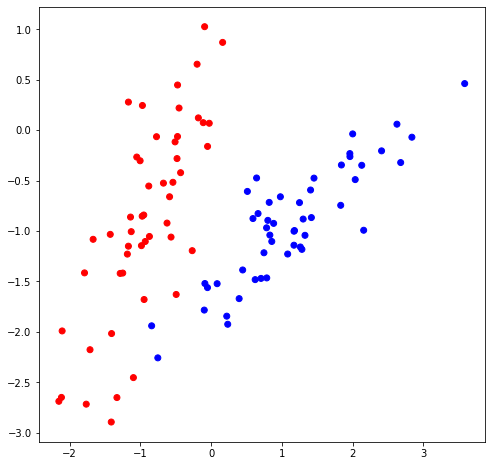

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        

In [66]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self, mean=False):
        if mean:
          return 0 if len(self.labels) == 0 else sum(self.labels)/len(self.labels)
        else:
          # подсчет количества объектов разных классов
          classes = {}  # сформируем словарь "класс: количество объектов"
          for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
          #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
          prediction = max(classes, key=classes.get)
          return prediction 

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет критерия энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= 0 if p == 0 else p * np.log2(p)        
    return impurity

In [8]:
# Расчет качества

def quality(left_labels, right_labels, current_criteria, criteria_call):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    print('current_criteria = {current_criteria} left = {criteria_call(left_labels)} right = {criteria_call(right_labels)}')
    return current_criteria - p * criteria_call(left_labels) - (1 - p) * criteria_call(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [49]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels, constraint_split_call, get_features_index_call, criteria_call):

    current_criteria = criteria_call(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    features_index = get_features_index_call(data)
    
    for index in features_index:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if constraint_split_call(true_data, false_data, true_labels, false_labels):
                continue
            
            current_quality = quality(true_labels, false_labels, current_criteria, criteria_call=criteria_call)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [11]:
def constraint_split_default(true_data, false_data, true_labels, false_labels):
  return False

def get_features_index_default(data):
  return [index for index in range(data.shape[1])]

def constraint_build_tree_default(quality, t, index, level):
  return quality == 0

In [12]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, 
               constraint_split_call=constraint_split_default, 
               get_features_index_call=get_features_index_default, 
               constraint_build_tree_call=constraint_build_tree_default, 
               criteria_call=gini,
               level=0):

    quality, t, index = find_best_split(data, labels, constraint_split_call, get_features_index_call, criteria_call)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if constraint_build_tree_call(quality, t, index, level):
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, 
                             constraint_split_call=constraint_split_call, 
                             get_features_index_call=get_features_index_call, 
                             constraint_build_tree_call=constraint_build_tree_call, 
                             criteria_call=criteria_call,
                             level=level+1)
    false_branch = build_tree(false_data, false_labels, 
                              constraint_split_call=constraint_split_call, 
                              get_features_index_call=get_features_index_call, 
                              constraint_build_tree_call=constraint_build_tree_call,
                              criteria_call=criteria_call, 
                              level=level+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def classify_object(obj, node, mean):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.predict(mean)
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch, mean)
    else:
        return classify_object(obj, node.false_branch, mean)

In [14]:
def predict(data, tree, mean=False):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree, mean)
        classes.append(prediction)
    return classes

In [15]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [16]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [17]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Индекс 0
        Порог -0.8411814419026544
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [18]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [19]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [20]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [21]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [22]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

Text(0.5, 1.0, 'Test accuracy=96.67')

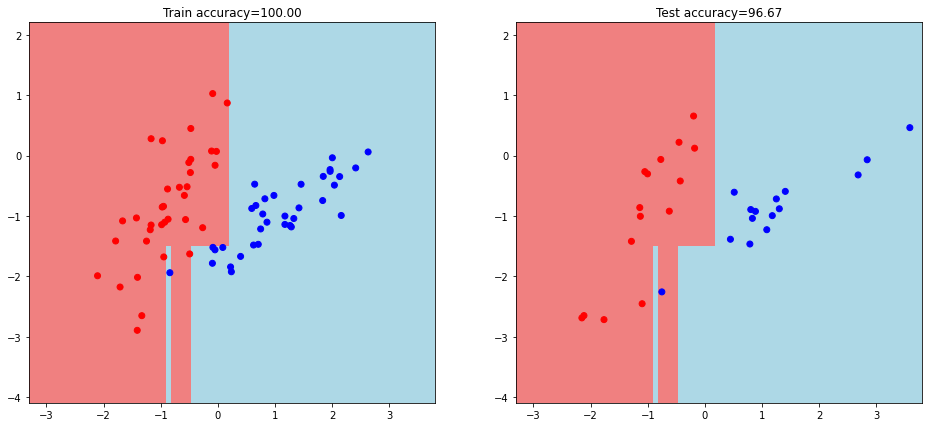

In [23]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Проверем качество построения дерева при ограничении на количестве объектов в листе от 1 до 10

In [24]:
def constraint_split_min_leaf(min_leaf):
  def constraint_split_min_leaf_(true_data, false_data, true_labels, false_labels):
    return len(true_data) < min_leaf or len(false_data) < min_leaf
  return constraint_split_min_leaf_


In [25]:
for min_leaf in range(1, 11):
  my_tree = build_tree(train_data, train_labels, constraint_split_call=constraint_split_min_leaf(min_leaf))
  train_answers = predict(train_data, my_tree)
  answers = predict(test_data, my_tree)
  print(f'Min leaf = {min_leaf} Train = {accuracy_metric(train_labels, train_answers)} Test = {accuracy_metric(test_labels, answers)}')


Min leaf = 1 Train = 100.0 Test = 96.66666666666667
Min leaf = 2 Train = 98.57142857142858 Test = 100.0
Min leaf = 3 Train = 98.57142857142858 Test = 100.0
Min leaf = 4 Train = 98.57142857142858 Test = 100.0
Min leaf = 5 Train = 98.57142857142858 Test = 100.0
Min leaf = 6 Train = 98.57142857142858 Test = 100.0
Min leaf = 7 Train = 92.85714285714286 Test = 96.66666666666667
Min leaf = 8 Train = 92.85714285714286 Test = 96.66666666666667
Min leaf = 9 Train = 92.85714285714286 Test = 96.66666666666667
Min leaf = 10 Train = 92.85714285714286 Test = 96.66666666666667


Проверем качество построения дерева при ограничении на глубину дерева от 1 до 10

In [26]:
def constraint_build_tree_max_level(max_level):
  def constraint_build_tree_max_level_(quality, t, index, level):
    if quality == 0:
      return True
    if level > max_level:
      return True
    return False
  return constraint_build_tree_max_level_

In [27]:
for max_level in range(1, 11):
  my_tree = build_tree(train_data, train_labels, constraint_build_tree_call=constraint_build_tree_max_level(max_level))
  train_answers = predict(train_data, my_tree)
  answers = predict(test_data, my_tree)
  print(f'max_level = {max_level} Train = {accuracy_metric(train_labels, train_answers)} Test = {accuracy_metric(test_labels, answers)}')

max_level = 1 Train = 92.85714285714286 Test = 96.66666666666667
max_level = 2 Train = 98.57142857142858 Test = 100.0
max_level = 3 Train = 98.57142857142858 Test = 100.0
max_level = 4 Train = 100.0 Test = 96.66666666666667
max_level = 5 Train = 100.0 Test = 96.66666666666667
max_level = 6 Train = 100.0 Test = 96.66666666666667
max_level = 7 Train = 100.0 Test = 96.66666666666667
max_level = 8 Train = 100.0 Test = 96.66666666666667
max_level = 9 Train = 100.0 Test = 96.66666666666667
max_level = 10 Train = 100.0 Test = 96.66666666666667


Проверем качество построения дерева на разных комбинациях признаков

In [28]:
def get_features_index1(features):
  def get_features_index1_(data):
    return features
  return get_features_index1_

In [29]:
for features in [[0],[1],[0,1],[1,0]]:
  my_tree = build_tree(train_data, train_labels, get_features_index_call=get_features_index1(features))
  train_answers = predict(train_data, my_tree)
  answers = predict(test_data, my_tree)
  print(f'features = {features} Train = {accuracy_metric(train_labels, train_answers)} Test = {accuracy_metric(test_labels, answers)}')

features = [0] Train = 100.0 Test = 96.66666666666667
features = [1] Train = 100.0 Test = 56.666666666666664
features = [0, 1] Train = 100.0 Test = 96.66666666666667
features = [1, 0] Train = 100.0 Test = 100.0


Последовательность перебора признаков оказалась важна.

##__2.__ Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [30]:
for max_level in range(1, 11):
  my_tree = build_tree(train_data, train_labels, constraint_build_tree_call=constraint_build_tree_max_level(max_level), criteria_call=gini)
  train_answers = predict(train_data, my_tree)
  answers = predict(test_data, my_tree)
  print(f'Джини max_level = {max_level} Train = {accuracy_metric(train_labels, train_answers)} Test = {accuracy_metric(test_labels, answers)}')
  
  my_tree = build_tree(train_data, train_labels, constraint_build_tree_call=constraint_build_tree_max_level(max_level), criteria_call=entropy)
  train_answers = predict(train_data, my_tree)
  answers = predict(test_data, my_tree)
  print(f'Энтр. max_level = {max_level} Train = {accuracy_metric(train_labels, train_answers)} Test = {accuracy_metric(test_labels, answers)}')

Джини max_level = 1 Train = 92.85714285714286 Test = 96.66666666666667
Энтр. max_level = 1 Train = 92.85714285714286 Test = 96.66666666666667
Джини max_level = 2 Train = 98.57142857142858 Test = 100.0
Энтр. max_level = 2 Train = 98.57142857142858 Test = 100.0
Джини max_level = 3 Train = 98.57142857142858 Test = 100.0
Энтр. max_level = 3 Train = 98.57142857142858 Test = 100.0
Джини max_level = 4 Train = 100.0 Test = 96.66666666666667
Энтр. max_level = 4 Train = 100.0 Test = 96.66666666666667
Джини max_level = 5 Train = 100.0 Test = 96.66666666666667
Энтр. max_level = 5 Train = 100.0 Test = 96.66666666666667
Джини max_level = 6 Train = 100.0 Test = 96.66666666666667
Энтр. max_level = 6 Train = 100.0 Test = 96.66666666666667
Джини max_level = 7 Train = 100.0 Test = 96.66666666666667
Энтр. max_level = 7 Train = 100.0 Test = 96.66666666666667
Джини max_level = 8 Train = 100.0 Test = 96.66666666666667
Энтр. max_level = 8 Train = 100.0 Test = 96.66666666666667
Джини max_level = 9 Train = 100.

##__3[опция].__ Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений

In [54]:
def variance(labels):
    v = labels.var()
    return v   

def calc_mse(y, y_pred):
    err = np.mean((y_pred-y)**2)
    return err


In [85]:
from sklearn import datasets as ds

#формируем исходные данные
X, y = ds.make_regression(n_samples=500, n_features=2, random_state=49)

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 1)

In [92]:
my_tree = build_tree(train_data, train_labels, constraint_split_call=constraint_split_min_leaf(20), criteria_call=variance)

In [93]:
  train_answers = predict(train_data, my_tree, mean=True)
  answers = predict(test_data, my_tree, mean=True)
  print(f'Min leaf = 20 Train = {calc_mse(train_labels, train_answers)} Test = {calc_mse(test_labels, answers)}')

Min leaf = 20 Train = 11.740173439893445 Test = 15.452017086499655
